In [1]:
from fastbook import *
from fastai.vision.widgets import *
import os

In [2]:
key = os.environ.get("AZURE_SEARCH_KEY")

In [3]:
sports_types = 'soccer','rugby','water polo'
path = Path('sports_players')

In [4]:
if not path.exists():
    path.mkdir()
    for o in sports_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} player')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [5]:
fns = get_image_files(path)
fns

(#442) [Path('sports_players/soccer/00000047.jpg'),Path('sports_players/soccer/00000055.jpg'),Path('sports_players/soccer/00000107.jpg'),Path('sports_players/soccer/00000036.jpg'),Path('sports_players/soccer/00000030.jpg'),Path('sports_players/soccer/00000097.jpg'),Path('sports_players/soccer/00000148.jpg'),Path('sports_players/soccer/00000110.jpg'),Path('sports_players/soccer/00000029.jpg'),Path('sports_players/soccer/00000112.jpg')...]

In [6]:
failed = verify_images(fns)
failed

(#0) []

In [7]:
failed.map(Path.unlink);

In [8]:
players = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [9]:
dls = players.dataloaders(path)

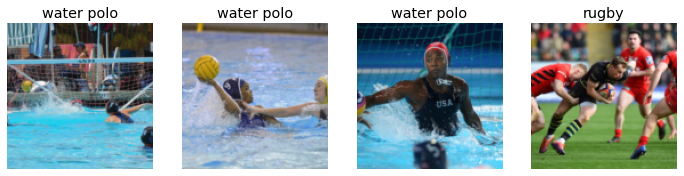

In [10]:
dls.valid.show_batch(max_n=4, nrows=1)

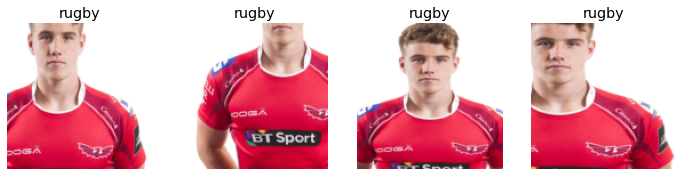

In [11]:
players = players.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = players.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

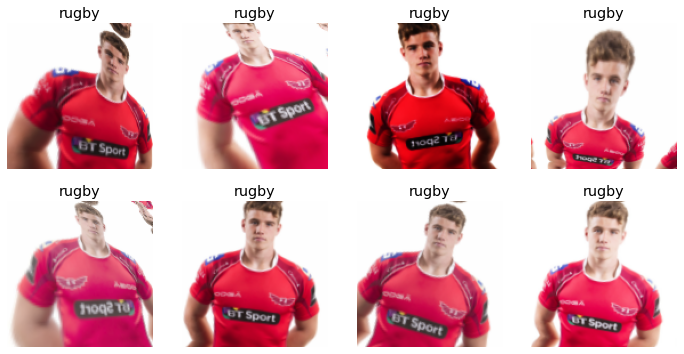

In [12]:
players = players.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = players.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [13]:
players = players.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = players.dataloaders(path)

In [14]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.814672,1.052623,0.397727,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.979888,0.530219,0.284091,00:07
1,0.783295,0.279224,0.113636,00:07
2,0.655197,0.211731,0.090909,00:07
3,0.584297,0.216884,0.090909,00:07


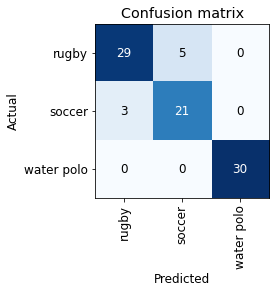

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

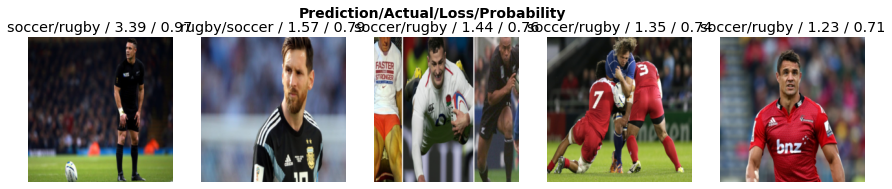

In [16]:
interp.plot_top_losses(5, nrows=1)

In [17]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [18]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# Export model and test inference

In [19]:
learn.export()

In [20]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [21]:
learn_inf = load_learner(path/'export.pkl')

In [22]:
ims = ['https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fs.hdnux.com%2Fphotos%2F31%2F54%2F35%2F6735734%2F3%2FrawImage.jpg&f=1&nofb=1']

In [23]:
dest = 'test_players/polo_player.jpg'
download_url(ims[0], dest)

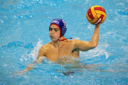

In [24]:
im = Image.open(dest)
im.to_thumb(128,128)

In [25]:
learn_inf.predict('test_players/polo_player.jpg')

('water polo',
 TensorImage(2),
 TensorImage([5.9805e-09, 1.4668e-07, 1.0000e+00]))

In [26]:
learn_inf.dls.vocab

['rugby', 'soccer', 'water polo']

In [27]:
ims = ["https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.wothappen.com%2Fwp-content%2Fuploads%2F2020%2F08%2FScreenshot_20200821-000254-1024x647.png&f=1&nofb=1"]

In [28]:
dest = 'test_players/soccer_player.jpg'
download_url(ims[0], dest)

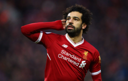

In [29]:
im = Image.open(dest)
im.to_thumb(128,128)

In [30]:
learn_inf.predict('test_players/soccer_player.jpg')

('soccer', TensorImage(1), TensorImage([2.3470e-02, 9.7604e-01, 4.8941e-04]))

In [31]:
ims = ["https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fe2.365dm.com%2F16%2F12%2F1600x900%2Fskysports-rugby-george-ford-bath_3852232.jpg&f=1&nofb=1"]

In [32]:
dest = 'test_players/rugby_player.jpg'
download_url(ims[0], dest)

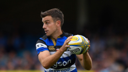

In [33]:
im = Image.open(dest)
im.to_thumb(128,128)

In [34]:
learn_inf.predict('test_players/rugby_player.jpg')

('rugby', TensorImage(0), TensorImage([0.8990, 0.0018, 0.0992]))

# Notebook App

In [35]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

In [36]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [37]:
VBox([widgets.Label('Select your sports player'), 
      btn_upload, btn_run, out_pl, lbl_pred])